In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import copy
import pickle
from torchvision import transforms

from get3d_utils import constructGenerator, eval_get3d_angles, generate_rotate_camera_list

In [2]:
def preprocess_rgb(array):
    img = array
    img = transforms.Normalize(mean=[-1.0, -1.0, -1.0], std=[2.0, 2.0, 2.0])(img)
    img = img.transpose(1, 3)
    img = img.transpose(1, 2)
    img = img.clip(0., 1.)
    return img.cpu().numpy()

In [3]:
with open('test.pickle', 'rb') as f:
        generator_args = pickle.load(f)

G_ema = constructGenerator(**generator_args)

constructing
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.
==> resume from pretrained path pretrained_model/shapenet_car.pt


In [4]:
torch.manual_seed(0)

In [5]:
loss_types = ['global', 'directional', 'pae']

states = {}

for loss_type in loss_types:
    states[loss_type] = torch.load(f'generators_saved/Hatchback_{loss_type}_generator.pt')

In [6]:
import copy

original_state_dict = copy.deepcopy(G_ema.state_dict())

In [7]:
n_samples = 32

z_geo = torch.randn(n_samples, 512).to('cuda')
z_tex = torch.randn(n_samples, 512).to('cuda')

with torch.no_grad():
    ws_geo = G_ema.mapping_geo(z_geo, c=torch.ones(1, device='cuda'), truncation_psi=0.7, update_emas=False)
    ws_tex = G_ema.mapping(z_tex, c=torch.ones(1, device='cuda'), truncation_psi=0.7, update_emas=False)

In [8]:
with torch.no_grad():
    camera_idxs = [0, 4, 8, 12, 16]
    cameras = generate_rotate_camera_list()
    cameras = [camera for i, camera in enumerate(cameras) if i in camera_idxs]
    imgs = []
    for i, _ in enumerate(ws_geo):
        G_ema.load_state_dict(original_state_dict)
        img_original = eval_get3d_angles(G_ema, ws_geo[i].unsqueeze(0).clone(), ws_tex[i].unsqueeze(0).clone(), cameras=cameras, intermediate_space=True).cpu()
        imgs.append(img_original)
    for loss_type in loss_types:
        G_ema.load_state_dict(states[loss_type])
        for i, _ in enumerate(ws_geo):
            img_edited = eval_get3d_angles(G_ema, ws_geo[i].unsqueeze(0).clone(), ws_tex[i].unsqueeze(0).clone(), cameras=cameras, intermediate_space=True).cpu()
            imgs.append(img_edited)
        torch.cuda.empty_cache()

/home/windows-ssh/git/GET3D/get3d_utils.py:351: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  camera_theta = torch.range(0, n_camera - 1, device='cuda').unsqueeze(dim=-1) / n_camera * math.pi * 2.0


In [9]:
imgs = torch.cat(imgs)

In [10]:
with torch.no_grad():
    preprocessed_imgs = preprocess_rgb(imgs)

In [11]:
preprocessed_imgs = preprocessed_imgs.reshape(-1, n_samples, len(cameras), 1024, 1024, 3).swapaxes(0, 1).reshape(-1, 1024, 1024, 3)

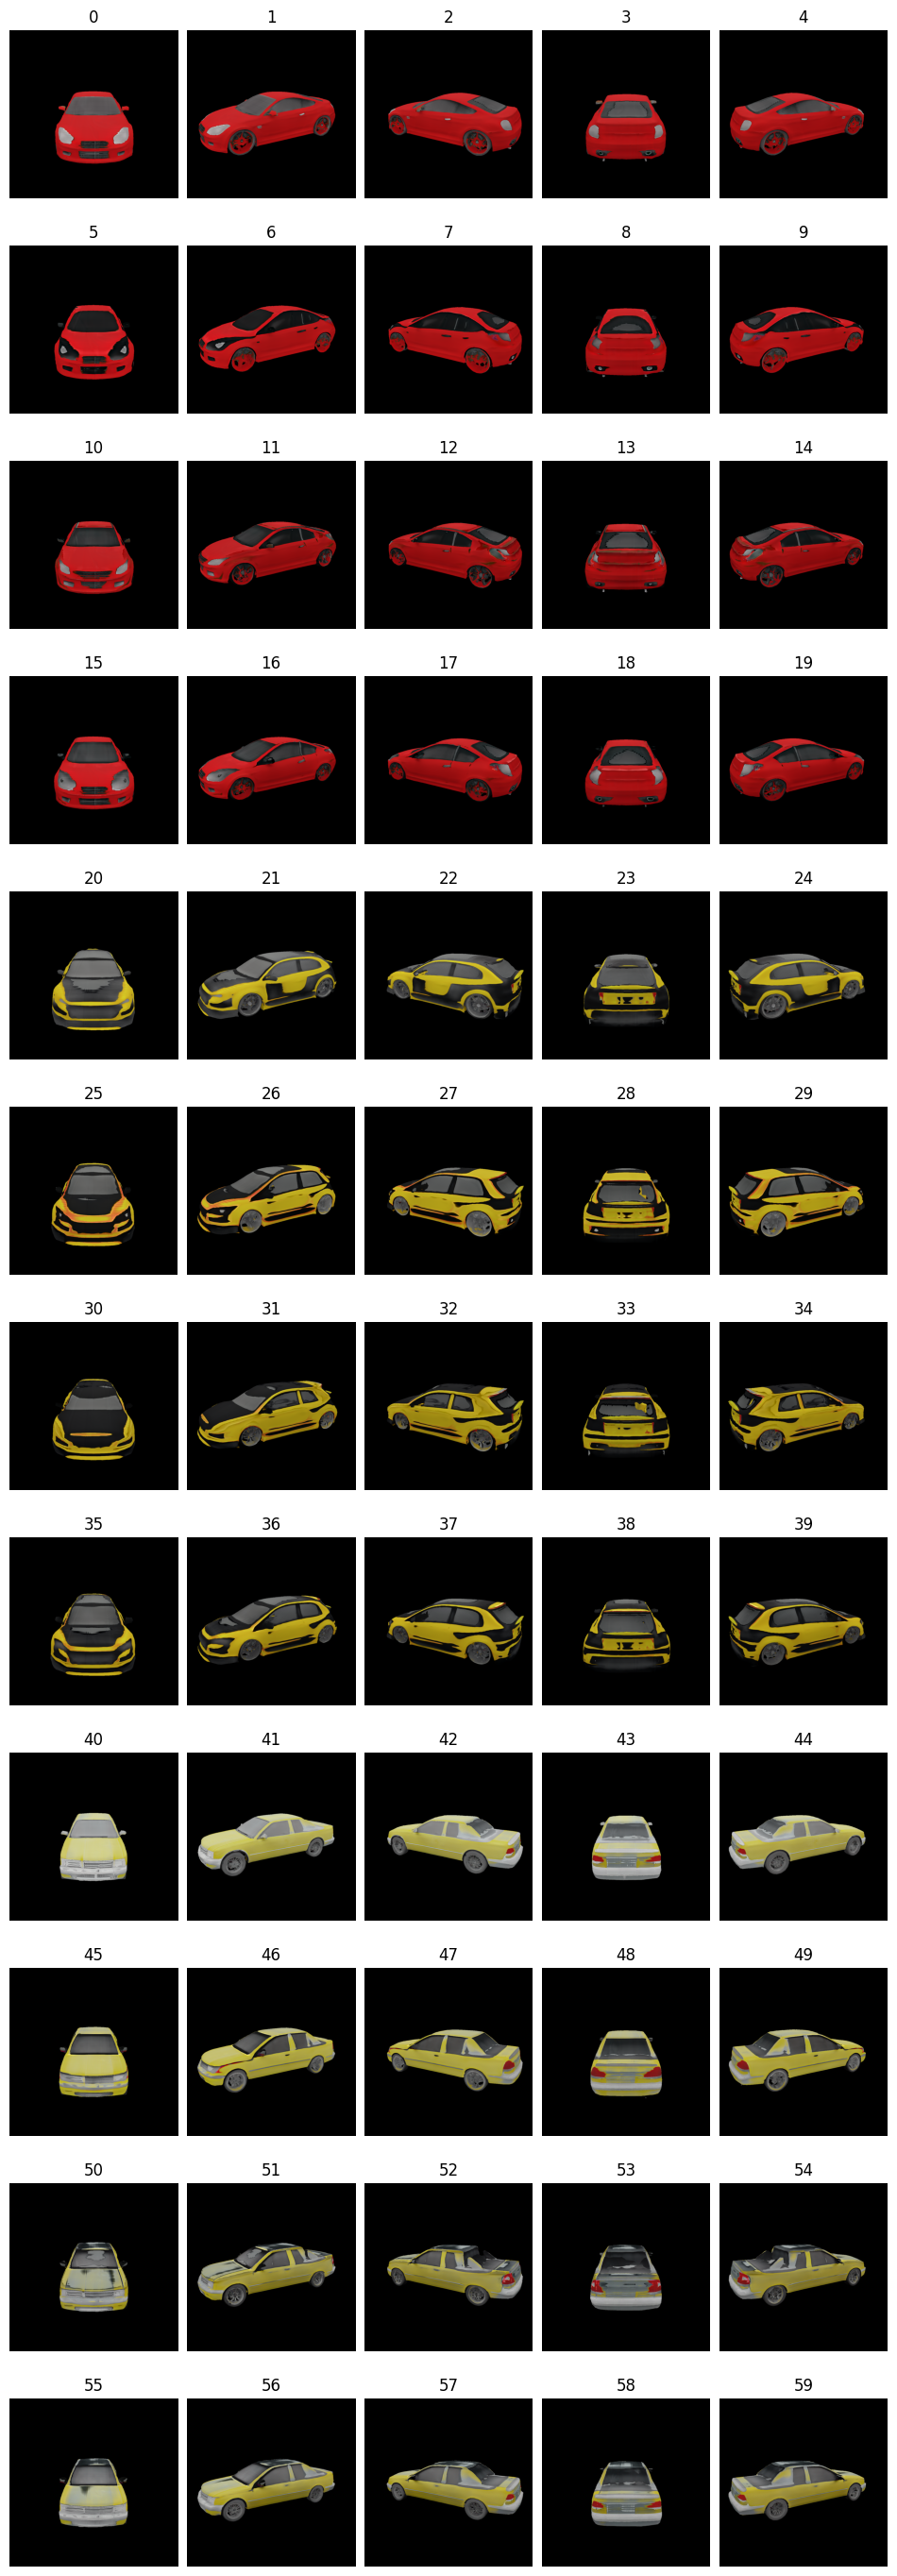

In [12]:
from mpl_toolkits.axes_grid1 import ImageGrid

n_show = 3

fig = plt.figure(figsize=(12., 200.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(n_show * (len(loss_types) + 1), len(cameras)),
                 axes_pad=(0.1, 0.5),
                 )

for i, (ax, im) in enumerate(zip(grid, preprocessed_imgs[:n_show * (len(loss_types) + 1) * len(cameras)])):
    ax.axis('off')
    ax.set_title(f'{i}')
    ax.imshow(im)

In [13]:
with open('weight_editing_Hatchback.pkl', 'wb') as f:
    pickle.dump(imgs, f)

In [12]:
with open('image_sample.pkl', 'wb') as f:
    pickle.dump(imgs, f)